# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from texttable import Texttable
import latextable

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import sys
sys.path.insert(1, '../sar_dirichlet')
import dirichlet_regression

In [4]:
from func_test import cos_similarity

In [5]:
scipy.__version__

'1.10.1'

# Loading Dataset

In [6]:
arctic = pd.read_csv('Data Dirichlet/ArcticLake.csv')

In [7]:
Y_arctic = arctic.iloc[:,:3]
X_arctic = arctic.iloc[:,3]

In [8]:
Y_arctic = np.array(Y_arctic)

In [9]:
X_arctic = np.array([[j] for j in X_arctic])

In [10]:
Z_arctic = np.ones(len(X_arctic)).reshape((39,1))

In [11]:
n_features = 1
n_classes = 3

In [12]:
X = np.array(X_arctic)
Y = np.array(Y_arctic)

X = StandardScaler().fit(X).transform(X)

In [13]:
Z = Z_arctic
gamma_0 = [0.]

In [14]:
n,K = X.shape
J = Y.shape[1]

# Order 1

In [15]:
distance_matrix = scipy.spatial.distance_matrix(X_arctic,X_arctic)
W_arctic_cont = np.zeros(np.shape(distance_matrix))
W_arctic_cont[distance_matrix < 28] = 1
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_arctic_cont,0)
# scaling the matrix, so that the sum of each row is 1
W_arctic_cont = W_arctic_cont/W_arctic_cont.sum(axis=1)[:,None]

In [16]:
pd.DataFrame(W_arctic_cont).to_csv("Data Dirichlet/W_arctic_cont.csv", index=False)

In [17]:
Minv09 = np.linalg.inv(np.identity(39) - 0.9*W_arctic_cont)
Minv08 = np.linalg.inv(np.identity(39) - 0.8*W_arctic_cont)
Minv075 = np.linalg.inv(np.identity(39) - 0.75*W_arctic_cont)
Minv07 = np.linalg.inv(np.identity(39) - 0.7*W_arctic_cont)
Minv06 = np.linalg.inv(np.identity(39) - 0.6*W_arctic_cont)

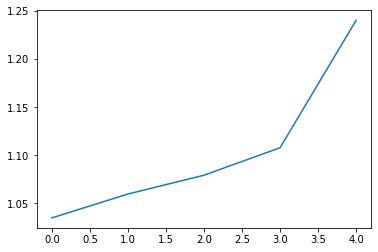

In [18]:
plt.plot([Minv06[0,0] , Minv07[0,0], Minv075[0,0], Minv08[0,0], Minv09[0,0]])
plt.show()

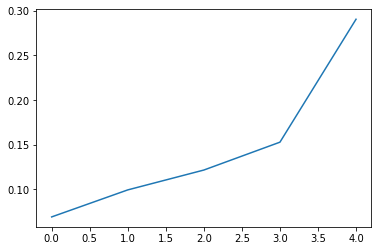

In [19]:
plt.plot([Minv06[0,1] , Minv07[0,1], Minv075[0,1], Minv08[0,1], Minv09[0,1]])
plt.show()

In [22]:
neighbors = NearestNeighbors(n_neighbors=29).fit(X)
W_arctic_dist = neighbors.kneighbors_graph(X,mode='distance').toarray()
W_arctic_dist[W_arctic_dist>0] = 1/W_arctic_dist[W_arctic_dist>0]
W_arctic_dist = W_arctic_dist/W_arctic_dist.sum(axis=1)[:,None]

In [23]:
pd.DataFrame(W_arctic_dist).to_csv("Data Dirichlet/W_arctic_dist.csv", index=False)

## Dirichlet model

In [18]:
%%time
list_r2_ns_1, list_rmse_ns_1, list_aic_ns_1, list_crossentropy_ns_1, list_similarity_ns_1 = [], [], [], [], []
list_r2_cont_1, list_rmse_cont_1, list_aic_cont_1, list_crossentropy_cont_1, list_similarity_cont_1 = [], [], [], [], []
list_r2_dist_1, list_rmse_dist_1, list_aic_dist_1, list_crossentropy_dist_1, list_similarity_dist_1 = [], [], [], [], []

for i in range(39):  
    X_temp = np.delete(X,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    
    Wss_cont = np.delete(W_arctic_cont,i,axis=0)
    Wss_cont = np.delete(Wss_cont,i,axis=1)
    Wss_cont = Wss_cont/Wss_cont.sum(axis=1)[:,None]
    
    Wss_dist = np.delete(W_arctic_dist,i,axis=0)
    Wss_dist = np.delete(Wss_dist,i,axis=1)
    Wss_dist = Wss_dist/Wss_dist.sum(axis=1)[:,None]
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=False)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp)
    list_r2_ns_1.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_ns_1.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_ns_1.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_aic_ns_1.append(-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor.mu,dirichRegressor.phi,Y_temp)+2*5)
    list_similarity_ns_1.append(cos_similarity(Y_temp,dirichRegressor.mu))

    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_cont)
    list_r2_cont_1.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_cont_1.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_cont_1.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_aic_cont_1.append(-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor.mu,dirichRegressor.phi,Y_temp)+2*6)
    list_similarity_cont_1.append(cos_similarity(Y_temp,dirichRegressor.mu))
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_dist)
    list_r2_dist_1.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_dist_1.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_dist_1.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_aic_dist_1.append(-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor.mu,dirichRegressor.phi,Y_temp)+2*6)
    list_similarity_dist_1.append(cos_similarity(Y_temp,dirichRegressor.mu))

Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimization terminated successfully.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimization terminated successfully.
CONVERGENCE: 

In [20]:
table = Texttable()
table.add_row(["Model", "$R^2$", "RMSE", "Cross-entropy", "Cos similarity", "AIC"])
text_r2 = str(np.round(np.mean(list_r2_ns_1),4))+" ("+str(np.round(np.std(list_r2_ns_1),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_ns_1),4))+" ("+str(np.round(np.std(list_rmse_ns_1),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_ns_1),4))+" ("+str(np.round(np.std(list_crossentropy_ns_1),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_ns_1),4))+" ("+str(np.round(np.std(list_similarity_ns_1),4))+")"
text_aic = str(np.round(np.mean(list_aic_ns_1),4))+" ("+str(np.round(np.std(list_aic_ns_1),4))+")"
table.add_row(["Not spatial", text_r2, text_rmse, text_crossentropy, text_similarity, text_aic])

text_r2 = str(np.round(np.mean(list_r2_cont_1),4))+" ("+str(np.round(np.std(list_r2_cont_1),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_cont_1),4))+" ("+str(np.round(np.std(list_rmse_cont_1),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_cont_1),4))+" ("+str(np.round(np.std(list_crossentropy_cont_1),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_cont_1),4))+" ("+str(np.round(np.std(list_similarity_cont_1),4))+")"
text_aic = str(np.round(np.mean(list_aic_cont_1),4))+" ("+str(np.round(np.std(list_aic_cont_1),4))+")"
table.add_row(["Contiguity", text_r2, text_rmse, text_crossentropy, text_similarity, text_aic])

text_r2 = str(np.round(np.mean(list_r2_dist_1),4))+" ("+str(np.round(np.std(list_r2_dist_1),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_dist_1),4))+" ("+str(np.round(np.std(list_rmse_dist_1),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_dist_1),4))+" ("+str(np.round(np.std(list_crossentropy_dist_1),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_dist_1),4))+" ("+str(np.round(np.std(list_similarity_dist_1),4))+")"
text_aic = str(np.round(np.mean(list_aic_dist_1),4))+" ("+str(np.round(np.std(list_aic_dist_1),4))+")"
table.add_row(["Distance", text_r2, text_rmse, text_crossentropy, text_similarity, text_aic])

print(table.draw())

+-------------+------------+------------+------------+------------+------------+
| Model       | $R^2$      | RMSE       | Cross-     | Cos        | AIC        |
|             |            |            | entropy    | similarity |            |
+-------------+------------+------------+------------+------------+------------+
| Not spatial | 0.5887     | 0.1015     | 0.9134     | 0.9665     | -141.6354  |
|             | (0.015)    | (0.0018)   | (0.0027)   | (0.0012)   | (2.2535)   |
+-------------+------------+------------+------------+------------+------------+
| Contiguity  | 0.6323     | 0.0951     | 0.9064     | 0.9706     | -149.5112  |
|             | (0.0147)   | (0.0017)   | (0.0029)   | (0.0011)   | (2.3333)   |
+-------------+------------+------------+------------+------------+------------+
| Distance    | 0.5893     | 0.1014     | 0.9134     | 0.9665     | -139.732   |
|             | (0.0148)   | (0.0018)   | (0.0027)   | (0.0012)   | (2.2448)   |
+-------------+------------+

## Cross-entropy

In [22]:
%%time
list_r2_ns_1_ce, list_rmse_ns_1_ce, list_crossentropy_ns_1_ce, list_similarity_ns_1_ce = [], [], [], []
list_r2_cont_1_ce, list_rmse_cont_1_ce, list_crossentropy_cont_1_ce, list_similarity_cont_1_ce = [], [], [], []
list_r2_dist_1_ce, list_rmse_dist_1_ce, list_crossentropy_dist_1_ce, list_similarity_dist_1_ce = [], [], [], []

for i in range(39):  
    X_temp = np.delete(X_arctic,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    
    Wss_cont = np.delete(W_arctic_cont,i,axis=0)
    Wss_cont = np.delete(Wss_cont,i,axis=1)
    Wss_cont = Wss_cont/Wss_cont.sum(axis=1)[:,None]
    
    Wss_dist = np.delete(W_arctic_dist,i,axis=0)
    Wss_dist = np.delete(Wss_dist,i,axis=1)
    Wss_dist = Wss_dist/Wss_dist.sum(axis=1)[:,None]
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=False)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, loss='crossentropy')
    list_r2_ns_1_ce.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_ns_1_ce.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_ns_1_ce.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_similarity_ns_1_ce.append(cos_similarity(Y_temp,dirichRegressor.mu))

    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_cont, loss='crossentropy')
    list_r2_cont_1_ce.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_cont_1_ce.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_cont_1_ce.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_similarity_cont_1_ce.append(cos_similarity(Y_temp,dirichRegressor.mu))
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_dist, loss='crossentropy')
    list_r2_dist_1_ce.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_dist_1_ce.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_dist_1_ce.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_similarity_dist_1_ce.append(cos_similarity(Y_temp,dirichRegressor.mu))


Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

In [50]:
table = Texttable()
table.add_row(["Model", "$R^2$", "RMSE", "Cross-entropy", "Cos similarity"])
text_r2 = str(np.round(np.mean(list_r2_ns_1_ce),4))+" ("+str(np.round(np.std(list_r2_ns_1_ce),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_ns_1_ce),4))+" ("+str(np.round(np.std(list_rmse_ns_1_ce),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_ns_1_ce),4))+" ("+str(np.round(np.std(list_crossentropy_ns_1_ce),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_ns_1_ce),4))+" ("+str(np.round(np.std(list_similarity_ns_1_ce),4))+")"
table.add_row(["Not spatial", text_r2, text_rmse, text_crossentropy, text_similarity])

text_r2 = str(np.round(np.mean(list_r2_cont_1_ce),4))+" ("+str(np.round(np.std(list_r2_cont_1_ce),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_cont_1_ce),4))+" ("+str(np.round(np.std(list_rmse_cont_1_ce),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_cont_1_ce),4))+" ("+str(np.round(np.std(list_crossentropy_cont_1_ce),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_cont_1_ce),4))+" ("+str(np.round(np.std(list_similarity_cont_1_ce),4))+")"
table.add_row(["Contiguity", text_r2, text_rmse, text_crossentropy, text_similarity])

text_r2 = str(np.round(np.mean(list_r2_dist_1_ce),4))+" ("+str(np.round(np.std(list_r2_dist_1_ce),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_dist_1_ce),4))+" ("+str(np.round(np.std(list_rmse_dist_1_ce),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_dist_1_ce),4))+" ("+str(np.round(np.std(list_crossentropy_dist_1_ce),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_dist_1_ce),4))+" ("+str(np.round(np.std(list_similarity_dist_1_ce),4))+")"
table.add_row(["Distance", text_r2, text_rmse, text_crossentropy, text_similarity])

print(table.draw())

+-------------+----------------+---------------+---------------+---------------+
| Model       | $R^2$          | RMSE          | Cross-entropy | Cos           |
|             |                |               |               | similarity    |
+-------------+----------------+---------------+---------------+---------------+
| Not spatial | 0.6275         | 0.0961        | 0.9106        | 0.97 (0.001)  |
|             | (0.0132)       | (0.0016)      | (0.0027)      |               |
+-------------+----------------+---------------+---------------+---------------+
| Contiguity  | 0.667 (0.0135) | 0.0899        | 0.9025        | 0.9735        |
|             |                | (0.0018)      | (0.003)       | (0.0011)      |
+-------------+----------------+---------------+---------------+---------------+
| Distance    | 0.6325         | 0.0946        | 0.9087        | 0.971         |
|             | (0.0132)       | (0.0018)      | (0.0026)      | (0.0012)      |
+-------------+-------------

# Order 2

In [20]:
X_2 = np.ones((39,3))
X_2[:,1] = X[:,0]
X_2[:,2] = X[:,0]**2

## Dirichlet model

In [25]:
%%time
list_r2_ns_2, list_rmse_ns_2, list_aic_ns_2, list_crossentropy_ns_2, list_similarity_ns_2 = [], [], [], [], []
list_r2_cont_2, list_rmse_cont_2, list_aic_cont_2, list_crossentropy_cont_2, list_similarity_cont_2 = [], [], [], [], []
list_r2_dist_2, list_rmse_dist_2, list_aic_dist_2, list_crossentropy_dist_2, list_similarity_dist_2 = [], [], [], [], []

for i in range(39):  
    X_temp = np.delete(X_2,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    
    Wss_cont = np.delete(W_arctic_cont,i,axis=0)
    Wss_cont = np.delete(Wss_cont,i,axis=1)
    Wss_cont = Wss_cont/Wss_cont.sum(axis=1)[:,None]
    
    Wss_dist = np.delete(W_arctic_dist,i,axis=0)
    Wss_dist = np.delete(Wss_dist,i,axis=1)
    Wss_dist = Wss_dist/Wss_dist.sum(axis=1)[:,None]
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=False)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp)
    list_r2_ns_2.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_ns_2.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_ns_2.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_aic_ns_2.append(-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor.mu,dirichRegressor.phi,Y_temp)+2*5)
    list_similarity_ns_2.append(cos_similarity(Y_temp,dirichRegressor.mu))

    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_cont)
    list_r2_cont_2.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_cont_2.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_cont_2.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_aic_cont_2.append(-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor.mu,dirichRegressor.phi,Y_temp)+2*6)
    list_similarity_cont_2.append(cos_similarity(Y_temp,dirichRegressor.mu))
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_dist)
    list_r2_dist_2.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_dist_2.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_dist_2.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_aic_dist_2.append(-2*dirichlet_regression.dirichlet_loglikelihood(dirichRegressor.mu,dirichRegressor.phi,Y_temp)+2*6)
    list_similarity_dist_2.append(cos_similarity(Y_temp,dirichRegressor.mu))

Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimization terminated successfully.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Optimization terminated successfully.
CONVERGENCE: NORM_

In [26]:
table = Texttable()
table.add_row(["Model", "$R^2$", "RMSE", "Cross-entropy", "Cos similarity", "AIC"])
text_r2 = str(np.round(np.mean(list_r2_ns_2),4))+" ("+str(np.round(np.std(list_r2_ns_2),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_ns_2),4))+" ("+str(np.round(np.std(list_rmse_ns_2),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_ns_2),4))+" ("+str(np.round(np.std(list_crossentropy_ns_2),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_ns_2),4))+" ("+str(np.round(np.std(list_similarity_ns_2),4))+")"
text_aic = str(np.round(np.mean(list_aic_ns_2),4))+" ("+str(np.round(np.std(list_aic_ns_2),4))+")"
table.add_row(["Not spatial", text_r2, text_rmse, text_crossentropy, text_similarity, text_aic])

text_r2 = str(np.round(np.mean(list_r2_cont_2),4))+" ("+str(np.round(np.std(list_r2_cont_2),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_cont_2),4))+" ("+str(np.round(np.std(list_rmse_cont_2),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_cont_2),4))+" ("+str(np.round(np.std(list_crossentropy_cont_2),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_cont_2),4))+" ("+str(np.round(np.std(list_similarity_cont_2),4))+")"
text_aic = str(np.round(np.mean(list_aic_cont_2),4))+" ("+str(np.round(np.std(list_aic_cont_2),4))+")"
table.add_row(["Contiguity", text_r2, text_rmse, text_crossentropy, text_similarity, text_aic])

text_r2 = str(np.round(np.mean(list_r2_dist_2),4))+" ("+str(np.round(np.std(list_r2_dist_2),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_dist_2),4))+" ("+str(np.round(np.std(list_rmse_dist_2),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_dist_2),4))+" ("+str(np.round(np.std(list_crossentropy_dist_2),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_dist_2),4))+" ("+str(np.round(np.std(list_similarity_dist_2),4))+")"
text_aic = str(np.round(np.mean(list_aic_dist_2),4))+" ("+str(np.round(np.std(list_aic_dist_2),4))+")"
table.add_row(["Distance", text_r2, text_rmse, text_crossentropy, text_similarity, text_aic])

print(table.draw())

+-------------+------------+------------+------------+------------+------------+
| Model       | $R^2$      | RMSE       | Cross-     | Cos        | AIC        |
|             |            |            | entropy    | similarity |            |
+-------------+------------+------------+------------+------------+------------+
| Not spatial | 0.6784     | 0.0881     | 0.8993     | 0.9743     | -168.1221  |
|             | (0.0144)   | (0.0019)   | (0.0032)   | (0.0011)   | (3.3212)   |
+-------------+------------+------------+------------+------------+------------+
| Contiguity  | 0.6943     | 0.0858     | 0.8974     | 0.9755     | -170.6099  |
|             | (0.0144)   | (0.0019)   | (0.0033)   | (0.0011)   | (3.6367)   |
+-------------+------------+------------+------------+------------+------------+
| Distance    | 0.6861     | 0.0871     | 0.8982     | 0.9747     | -167.138   |
|             | (0.0148)   | (0.002)    | (0.0032)   | (0.0012)   | (3.491)    |
+-------------+------------+

## Cross-entropy

In [21]:
%%time
list_r2_ns_2_ce, list_rmse_ns_2_ce, list_crossentropy_ns_2_ce, list_similarity_ns_2_ce = [], [], [], []
list_r2_cont_2_ce, list_rmse_cont_2_ce, list_crossentropy_cont_2_ce, list_similarity_cont_2_ce = [], [], [], []
list_r2_dist_2_ce, list_rmse_dist_2_ce, list_crossentropy_dist_2_ce, list_similarity_dist_2_ce = [], [], [], []

for i in range(39):  
    X_temp = np.delete(X_2,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    
    Wss_cont = np.delete(W_arctic_cont,i,axis=0)
    Wss_cont = np.delete(Wss_cont,i,axis=1)
    Wss_cont = Wss_cont/Wss_cont.sum(axis=1)[:,None]
    
    Wss_dist = np.delete(W_arctic_dist,i,axis=0)
    Wss_dist = np.delete(Wss_dist,i,axis=1)
    Wss_dist = Wss_dist/Wss_dist.sum(axis=1)[:,None]
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=False)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, loss='crossentropy')
    list_r2_ns_2_ce.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_ns_2_ce.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_ns_2_ce.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_similarity_ns_2_ce.append(cos_similarity(Y_temp,dirichRegressor.mu))

    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_cont, loss='crossentropy')
    list_r2_cont_2_ce.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_cont_2_ce.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_cont_2_ce.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_similarity_cont_2_ce.append(cos_similarity(Y_temp,dirichRegressor.mu))
    
    dirichRegressor = dirichlet_regression.dirichletRegressor(spatial=True)
    dirichRegressor.fit(X_temp, Y_temp, parametrization='alternative', gamma_0=gamma_0, Z=Z_temp, W=Wss_dist, loss='crossentropy')
    list_r2_dist_2_ce.append(r2_score(Y_temp,dirichRegressor.mu))
    list_rmse_dist_2_ce.append(mean_squared_error(Y_temp,dirichRegressor.mu,squared=False))
    list_crossentropy_dist_2_ce.append(-1/n*np.sum(Y_temp*np.log(dirichRegressor.mu)))
    list_similarity_dist_2_ce.append(cos_similarity(Y_temp,dirichRegressor.mu))

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization

In [22]:
table = Texttable()
table.add_row(["Model", "$R^2$", "RMSE", "Cross-entropy", "Cos similarity"])
text_r2 = str(np.round(np.mean(list_r2_ns_2_ce),4))+" ("+str(np.round(np.std(list_r2_ns_2_ce),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_ns_2_ce),4))+" ("+str(np.round(np.std(list_rmse_ns_2_ce),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_ns_2_ce),4))+" ("+str(np.round(np.std(list_crossentropy_ns_2_ce),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_ns_2_ce),4))+" ("+str(np.round(np.std(list_similarity_ns_2_ce),4))+")"
table.add_row(["Not spatial", text_r2, text_rmse, text_crossentropy, text_similarity])

text_r2 = str(np.round(np.mean(list_r2_cont_2_ce),4))+" ("+str(np.round(np.std(list_r2_cont_2_ce),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_cont_2_ce),4))+" ("+str(np.round(np.std(list_rmse_cont_2_ce),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_cont_2_ce),4))+" ("+str(np.round(np.std(list_crossentropy_cont_2_ce),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_cont_2_ce),4))+" ("+str(np.round(np.std(list_similarity_cont_2_ce),4))+")"
table.add_row(["Contiguity", text_r2, text_rmse, text_crossentropy, text_similarity])

text_r2 = str(np.round(np.mean(list_r2_dist_2_ce),4))+" ("+str(np.round(np.std(list_r2_dist_2_ce),4))+")"
text_rmse = str(np.round(np.mean(list_rmse_dist_2_ce),4))+" ("+str(np.round(np.std(list_rmse_dist_2_ce),4))+")"
text_crossentropy = str(np.round(np.mean(list_crossentropy_dist_2_ce),4))+" ("+str(np.round(np.std(list_crossentropy_dist_2_ce),4))+")"
text_similarity = str(np.round(np.mean(list_similarity_dist_2_ce),4))+" ("+str(np.round(np.std(list_similarity_dist_2_ce),4))+")"
table.add_row(["Distance", text_r2, text_rmse, text_crossentropy, text_similarity])

print(table.draw())

+-------------+----------------+---------------+---------------+---------------+
| Model       | $R^2$          | RMSE          | Cross-entropy | Cos           |
|             |                |               |               | similarity    |
+-------------+----------------+---------------+---------------+---------------+
| Not spatial | 0.689 (0.0134) | 0.0869        | 0.8983        | 0.9748        |
|             |                | (0.0018)      | (0.0031)      | (0.0011)      |
+-------------+----------------+---------------+---------------+---------------+
| Contiguity  | 0.7047         | 0.0848        | 0.8963        | 0.9759        |
|             | (0.0136)       | (0.0019)      | (0.0033)      | (0.0011)      |
+-------------+----------------+---------------+---------------+---------------+
| Distance    | 0.7051         | 0.0842        | 0.8948        | 0.9763        |
|             | (0.0159)       | (0.0026)      | (0.0031)      | (0.0014)      |
+-------------+-------------